# Prev

## include

In [1]:
include("../../src/struct_data.jl")
include("../../src/neighbor.jl")
include("../../src/forces/forces.jl")
include("../../src/run_event.jl")

RunFusionAggregates (generic function with 1 method)

## model

In [2]:
@time model = ModelSet(
    TimeModel(
        tₛᵢₘ  = 150000.0,
        dt    = 0.5,
        nₖₙₙ  = 100,
        nₛₐᵥₑ = 50
    ),
    InputModel(
        outer_ratio = 0.8,
        path_input  = "../../data/init/Sphere"
    ),
    OutputModel(
        name_output = "Test_1",
        path_output = "",
        d_saved = 0.5
    ) 
)

  0.000003 seconds (5 allocations: 208 bytes)


ModelSet(TimeModel(150000.0, 0.5, 100, 50), InputModel(0.8, "../../data/init/Sphere"), OutputModel("Test_1", "", 0.5))

# Run

## Some Founded Parameters

### Cubic

In [3]:
# # Complete (Oriola Contractile Model) -> Normal Vectors of distance between cells without area
# Par1, Par2 = Cubic(0.0055,2.0,4.5), ContractilePar(0.162);
# Par1, Par2 = Cubic(0.0055,2.0,4.5), ContractilePar(0.166);
# Par1, Par2 = Cubic(0.0055,2.0,4.5), ContractilePar(0.164);

## Fusion Agg

In [4]:
# Run Model
Par1 ,Par2 = Cubic(0.07,2.0,3.0), ContractilePar(0.267,pi/4,0.08,1.0)
# ContractilePar(0.02);
# RunFusionAggregates(model::ModelSet, Par1, Par2, 15)
size_agg = 15

15

In [5]:
# Run only one aggregate
agg = nothing
agg = Aggregate(
    [AggType(
        "HEK_1", 
        InteractionPar(Par1, Par2),
        Float32.(readdlm("../../data/init/Sphere/$(size_agg).0.xyz")[3:end,2:end]) |> cu
    )], 
    [AggLocation("HEK_1",[0 0 0]),],
    model
)

Aggregate(AggType[AggType("HEK_1", InteractionPar(Cubic{Float64}(0.07, 2.0, 3.0), ContractilePar{Float64}(0.267, 0.7853981633974483, 0.08, 1.0)), 15.27f0, Float32[-1.5 -4.62 -13.88; 0.5 -4.62 -13.88; … ; 0.5 4.62 13.88; 2.5 4.62 13.88], CuArray{Float32, 2, CUDA.Mem.DeviceBuffer})], AggIndex([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ["HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1"  …  "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1"]), Float32[-1.5 -4.62 -13.88; 0.5 -4.62 -13.88; … ; 0.5 4.62 13.88; 2.5 4.62 13.88], AggGeometry(Float32[15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27  …  15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (-14.5f0, 14.5f0)), AggSimulation(AggParameter(Cubic{CuArray{Float32, 1, CUDA.Mem

In [6]:
run_test(agg, model,"Run One Aggregate", false, false)

Run One Aggregate...   0%|                               |  ETA: 22.15 days

Run One Aggregate...   3%|█                              |  ETA: 0:06:38

Run One Aggregate...   4%|█▎                             |  ETA: 0:05:22

Run One Aggregate...   6%|█▊                             |  ETA: 0:04:00

Run One Aggregate...   6%|█▉                             |  ETA: 0:03:39

Run One Aggregate...   7%|██▎                            |  ETA: 0:03:06

Run One Aggregate...   8%|██▍                            |  ETA: 0:02:53

Run One Aggregate...   8%|██▋                            |  ETA: 0:02:43

Run One Aggregate...   9%|██▊                            |  ETA: 0:02:33

Run One Aggregate...   9%|██▉                            |  ETA: 0:02:25

Run One Aggregate...  10%|███▏                           |  ETA: 0:02:18

Run One Aggregate...  10%|███▎                           |  ETA: 0:02:12

Run One Aggregate...  11%|███▍                           |  ETA: 0:02:05

Run One Aggregate...  12%|███▋                           |  ETA: 0:01:59

Run One Aggregate...  12%|███▊                           |  ETA: 0:01:55

Run One Aggregate...  15%|████▋                          |  ETA: 0:01:33

Run One Aggregate...  15%|████▊                          |  ETA: 0:01:30

Run One Aggregate...  16%|████▉                          |  ETA: 0:01:27

Run One Aggregate...  16%|█████                          |  ETA: 0:01:25

Run One Aggregate...  17%|█████▎                         |  ETA: 0:01:22

Run One Aggregate...  17%|█████▍                         |  ETA: 0:01:19

Run One Aggregate...  18%|█████▌                         |  ETA: 0:01:17

Run One Aggregate...  18%|█████▊                         |  ETA: 0:01:15

Run One Aggregate...  19%|█████▉                         |  ETA: 0:01:13

Run One Aggregate...  19%|██████                         |  ETA: 0:01:11

Run One Aggregate...  20%|██████▏                        |  ETA: 0:01:10

Run One Aggregate...  20%|██████▎                        |  ETA: 0:01:08

Run One Aggregate...  21%|██████▌                        |  ETA: 0:01:06

Run One Aggregate...  21%|██████▋                        |  ETA: 0:01:05

Run One Aggregate...  22%|██████▊                        |  ETA: 0:01:03

Run One Aggregate...  22%|██████▉                        |  ETA: 0:01:02

Run One Aggregate...  23%|███████▏                       |  ETA: 0:01:00

Run One Aggregate...  23%|███████▎                       |  ETA: 0:00:59

Run One Aggregate...  24%|███████▍                       |  ETA: 0:00:58

Run One Aggregate...  24%|███████▋                       |  ETA: 0:00:57

Run One Aggregate...  25%|███████▊                       |  ETA: 0:00:55

Run One Aggregate...  25%|███████▉                       |  ETA: 0:00:54

Run One Aggregate...  26%|████████                       |  ETA: 0:00:53

Run One Aggregate...  26%|████████▏                      |  ETA: 0:00:52

Run One Aggregate...  27%|████████▍                      |  ETA: 0:00:51

Run One Aggregate...  27%|████████▌                      |  ETA: 0:00:50

Run One Aggregate...  28%|████████▋                      |  ETA: 0:00:49

Run One Aggregate...  28%|████████▊                      |  ETA: 0:00:49

Run One Aggregate...  29%|█████████                      |  ETA: 0:00:47

Run One Aggregate...  29%|█████████▏                     |  ETA: 0:00:46

Run One Aggregate...  30%|█████████▎                     |  ETA: 0:00:46

Run One Aggregate...  30%|█████████▍                     |  ETA: 0:00:45

Run One Aggregate...  31%|█████████▋                     |  ETA: 0:00:44

Run One Aggregate...  31%|█████████▊                     |  ETA: 0:00:43

Run One Aggregate...  32%|█████████▉                     |  ETA: 0:00:43

Run One Aggregate...  32%|██████████                     |  ETA: 0:00:42

Run One Aggregate...  33%|██████████▎                    |  ETA: 0:00:41

Run One Aggregate...  33%|██████████▍                    |  ETA: 0:00:40

Run One Aggregate...  34%|██████████▌                    |  ETA: 0:00:40

Run One Aggregate...  34%|██████████▋                    |  ETA: 0:00:39

Run One Aggregate...  35%|██████████▊                    |  ETA: 0:00:38

Run One Aggregate...  35%|███████████                    |  ETA: 0:00:38

Run One Aggregate...  36%|███████████▏                   |  ETA: 0:00:37

Run One Aggregate...  36%|███████████▎                   |  ETA: 0:00:37

Run One Aggregate...  37%|███████████▍                   |  ETA: 0:00:36

Run One Aggregate...  37%|███████████▋                   |  ETA: 0:00:35

Run One Aggregate...  38%|███████████▊                   |  ETA: 0:00:35

Run One Aggregate...  38%|███████████▉                   |  ETA: 0:00:34

Run One Aggregate...  39%|████████████                   |  ETA: 0:00:34

Run One Aggregate...  39%|████████████▎                  |  ETA: 0:00:33

Run One Aggregate...  40%|████████████▍                  |  ETA: 0:00:33

Run One Aggregate...  40%|████████████▌                  |  ETA: 0:00:32

Run One Aggregate...  41%|████████████▋                  |  ETA: 0:00:32

Run One Aggregate...  41%|████████████▉                  |  ETA: 0:00:31

Run One Aggregate...  42%|█████████████                  |  ETA: 0:00:31

Run One Aggregate...  42%|█████████████▏                 |  ETA: 0:00:30

Run One Aggregate...  43%|█████████████▎                 |  ETA: 0:00:30

Run One Aggregate...  43%|█████████████▌                 |  ETA: 0:00:29

Run One Aggregate...  44%|█████████████▋                 |  ETA: 0:00:29

Run One Aggregate...  44%|█████████████▊                 |  ETA: 0:00:28

Run One Aggregate...  45%|█████████████▉                 |  ETA: 0:00:28

Run One Aggregate...  45%|██████████████▏                |  ETA: 0:00:27

Run One Aggregate...  46%|██████████████▎                |  ETA: 0:00:27

Run One Aggregate...  46%|██████████████▍                |  ETA: 0:00:27

Run One Aggregate...  47%|██████████████▌                |  ETA: 0:00:26

Run One Aggregate...  47%|██████████████▊                |  ETA: 0:00:26

Run One Aggregate...  48%|██████████████▉                |  ETA: 0:00:25

Run One Aggregate...  48%|███████████████                |  ETA: 0:00:25

Run One Aggregate...  49%|███████████████▏               |  ETA: 0:00:25

Run One Aggregate...  49%|███████████████▍               |  ETA: 0:00:24

Run One Aggregate...  50%|███████████████▌               |  ETA: 0:00:24

Run One Aggregate...  50%|███████████████▋               |  ETA: 0:00:23

Run One Aggregate...  51%|███████████████▊               |  ETA: 0:00:23

Run One Aggregate...  51%|███████████████▉               |  ETA: 0:00:23

Run One Aggregate...  52%|████████████████▏              |  ETA: 0:00:22

Run One Aggregate...  52%|████████████████▎              |  ETA: 0:00:22

Run One Aggregate...  53%|████████████████▍              |  ETA: 0:00:22

Run One Aggregate...  53%|████████████████▌              |  ETA: 0:00:21

Run One Aggregate...  54%|████████████████▊              |  ETA: 0:00:21

Run One Aggregate...  54%|████████████████▉              |  ETA: 0:00:21

Run One Aggregate...  55%|█████████████████              |  ETA: 0:00:20

Run One Aggregate...  55%|█████████████████▏             |  ETA: 0:00:20

Run One Aggregate...  56%|█████████████████▍             |  ETA: 0:00:20

Run One Aggregate...  56%|█████████████████▌             |  ETA: 0:00:19

Run One Aggregate...  57%|█████████████████▋             |  ETA: 0:00:19

Run One Aggregate...  57%|█████████████████▊             |  ETA: 0:00:19

Run One Aggregate...  58%|██████████████████             |  ETA: 0:00:18

Run One Aggregate...  58%|██████████████████▏            |  ETA: 0:00:18

Run One Aggregate...  59%|██████████████████▎            |  ETA: 0:00:18

Run One Aggregate...  59%|██████████████████▍            |  ETA: 0:00:18

Run One Aggregate...  60%|██████████████████▌            |  ETA: 0:00:17

Run One Aggregate...  60%|██████████████████▊            |  ETA: 0:00:17

Run One Aggregate...  61%|██████████████████▉            |  ETA: 0:00:17

Run One Aggregate...  61%|███████████████████            |  ETA: 0:00:16

Run One Aggregate...  62%|███████████████████▏           |  ETA: 0:00:16

Run One Aggregate...  62%|███████████████████▍           |  ETA: 0:00:16

Run One Aggregate...  63%|███████████████████▌           |  ETA: 0:00:16

Run One Aggregate...  63%|███████████████████▋           |  ETA: 0:00:15

Run One Aggregate...  64%|███████████████████▊           |  ETA: 0:00:15

Run One Aggregate...  64%|████████████████████           |  ETA: 0:00:15

Run One Aggregate...  65%|████████████████████▏          |  ETA: 0:00:15

Run One Aggregate...  65%|████████████████████▎          |  ETA: 0:00:14

Run One Aggregate...  66%|████████████████████▍          |  ETA: 0:00:14

Run One Aggregate...  66%|████████████████████▋          |  ETA: 0:00:14

Run One Aggregate...  67%|████████████████████▊          |  ETA: 0:00:14

Run One Aggregate...  67%|████████████████████▉          |  ETA: 0:00:13

Run One Aggregate...  68%|█████████████████████          |  ETA: 0:00:13

Run One Aggregate...  68%|█████████████████████▏         |  ETA: 0:00:13

Run One Aggregate...  69%|█████████████████████▍         |  ETA: 0:00:13

Run One Aggregate...  69%|█████████████████████▌         |  ETA: 0:00:12

Run One Aggregate...  70%|█████████████████████▋         |  ETA: 0:00:12

Run One Aggregate...  70%|█████████████████████▊         |  ETA: 0:00:12

Run One Aggregate...  71%|██████████████████████         |  ETA: 0:00:12

Run One Aggregate...  71%|██████████████████████▏        |  ETA: 0:00:11

Run One Aggregate...  72%|██████████████████████▎        |  ETA: 0:00:11

Run One Aggregate...  72%|██████████████████████▍        |  ETA: 0:00:11

Run One Aggregate...  73%|██████████████████████▋        |  ETA: 0:00:11

Run One Aggregate...  73%|██████████████████████▊        |  ETA: 0:00:10

Run One Aggregate...  74%|██████████████████████▉        |  ETA: 0:00:10

Run One Aggregate...  74%|███████████████████████        |  ETA: 0:00:10

Run One Aggregate...  75%|███████████████████████▎       |  ETA: 0:00:10

Run One Aggregate...  75%|███████████████████████▍       |  ETA: 0:00:10

Run One Aggregate...  76%|███████████████████████▌       |  ETA: 0:00:09

Run One Aggregate...  76%|███████████████████████▋       |  ETA: 0:00:09

Run One Aggregate...  77%|███████████████████████▉       |  ETA: 0:00:09

Run One Aggregate...  77%|████████████████████████       |  ETA: 0:00:09

Run One Aggregate...  78%|████████████████████████▏      |  ETA: 0:00:08

Run One Aggregate...  78%|████████████████████████▎      |  ETA: 0:00:08

Run One Aggregate...  79%|████████████████████████▌      |  ETA: 0:00:08

Run One Aggregate...  79%|████████████████████████▋      |  ETA: 0:00:08

Run One Aggregate...  80%|████████████████████████▊      |  ETA: 0:00:08

Run One Aggregate...  80%|████████████████████████▉      |  ETA: 0:00:07

Run One Aggregate...  81%|█████████████████████████▏     |  ETA: 0:00:07

Run One Aggregate...  81%|█████████████████████████▎     |  ETA: 0:00:07

Run One Aggregate...  82%|█████████████████████████▍     |  ETA: 0:00:07

Run One Aggregate...  82%|█████████████████████████▌     |  ETA: 0:00:07

Run One Aggregate...  83%|█████████████████████████▊     |  ETA: 0:00:06

Run One Aggregate...  83%|█████████████████████████▉     |  ETA: 0:00:06

Run One Aggregate...  84%|██████████████████████████     |  ETA: 0:00:06

Run One Aggregate...  84%|██████████████████████████▏    |  ETA: 0:00:06

Run One Aggregate...  85%|██████████████████████████▎    |  ETA: 0:00:06

Run One Aggregate...  85%|██████████████████████████▌    |  ETA: 0:00:05

Run One Aggregate...  86%|██████████████████████████▋    |  ETA: 0:00:05

Run One Aggregate...  86%|██████████████████████████▊    |  ETA: 0:00:05

Run One Aggregate...  87%|██████████████████████████▉    |  ETA: 0:00:05

Run One Aggregate...  87%|███████████████████████████▏   |  ETA: 0:00:05

Run One Aggregate...  88%|███████████████████████████▎   |  ETA: 0:00:04

Run One Aggregate...  88%|███████████████████████████▍   |  ETA: 0:00:04

Run One Aggregate...  89%|███████████████████████████▌   |  ETA: 0:00:04

Run One Aggregate...  89%|███████████████████████████▊   |  ETA: 0:00:04

Run One Aggregate...  90%|███████████████████████████▉   |  ETA: 0:00:04

Run One Aggregate...  90%|████████████████████████████   |  ETA: 0:00:03

Run One Aggregate...  91%|████████████████████████████▏  |  ETA: 0:00:03

Run One Aggregate...  91%|████████████████████████████▍  |  ETA: 0:00:03

Run One Aggregate...  92%|████████████████████████████▌  |  ETA: 0:00:03

Run One Aggregate...  92%|████████████████████████████▋  |  ETA: 0:00:03

Run One Aggregate...  93%|████████████████████████████▊  |  ETA: 0:00:03

Run One Aggregate...  93%|█████████████████████████████  |  ETA: 0:00:02

Run One Aggregate...  94%|█████████████████████████████▏ |  ETA: 0:00:02

Run One Aggregate...  94%|█████████████████████████████▎ |  ETA: 0:00:02

Run One Aggregate...  95%|█████████████████████████████▍ |  ETA: 0:00:02

Run One Aggregate...  95%|█████████████████████████████▋ |  ETA: 0:00:02

Run One Aggregate...  96%|█████████████████████████████▊ |  ETA: 0:00:01

Run One Aggregate...  96%|█████████████████████████████▉ |  ETA: 0:00:01

Run One Aggregate...  97%|██████████████████████████████ |  ETA: 0:00:01

Run One Aggregate...  97%|██████████████████████████████▏|  ETA: 0:00:01

Run One Aggregate...  98%|██████████████████████████████▍|  ETA: 0:00:01

Run One Aggregate...  98%|██████████████████████████████▌|  ETA: 0:00:01

Run One Aggregate...  99%|██████████████████████████████▋|  ETA: 0:00:00

Run One Aggregate...  99%|██████████████████████████████▉|  ETA: 0:00:00

Run One Aggregate... 100%|███████████████████████████████|  ETA: 0:00:00

Run One Aggregate... 100%|███████████████████████████████| Time: 0:00:34


In [7]:
position=agg.Position
open("init_stable.xyz", "a") do f
    write(f, "Initial Stable\n")
    write(f, "t=0\n")
    writedlm(f,hcat(agg.Geometry.outline,Matrix(position)), ' ')
end

# Run fusion of two aggregates
agg = nothing
agg = FusionAggregate(
    [AggType("HEK_1", InteractionPar(Par1, Par2),position)], 
    model
)
run_test(agg, model, "Fusion of Two Aggregates", true, true)

# display(sum(isnan.(agg.Simulation.Force.F), dims=1))
# display(sum(agg.Simulation.Force.F .> 50, dims=1))
# display(agg.Simulation.Force.F)
# display(agg.Position)

Fusion of Two Aggregates...   1%|▏                       |  ETA: 0:00:22

Fusion of Two Aggregates...   1%|▎                       |  ETA: 0:00:27

Fusion of Two Aggregates...   1%|▍                       |  ETA: 0:00:28

Fusion of Two Aggregates...   2%|▍                       |  ETA: 0:00:29

Fusion of Two Aggregates...   2%|▌                       |  ETA: 0:00:30

Fusion of Two Aggregates...   2%|▌                       |  ETA: 0:00:32

Fusion of Two Aggregates...   3%|▋                       |  ETA: 0:00:31

Fusion of Two Aggregates...   3%|▊                       |  ETA: 0:00:31

Fusion of Two Aggregates...   3%|▉                       |  ETA: 0:00:31

Fusion of Two Aggregates...   4%|▉                       |  ETA: 0:00:31

Fusion of Two Aggregates...   4%|█                       |  ETA: 0:00:34

Fusion of Two Aggregates...   5%|█▎                      |  ETA: 0:00:31

Fusion of Two Aggregates...   6%|█▍                      |  ETA: 0:00:31

Fusion of Two Aggregates...   6%|█▌                      |  ETA: 0:00:33

Fusion of Two Aggregates...   8%|█▉                      |  ETA: 0:00:31

Fusion of Two Aggregates...   8%|█▉                      |  ETA: 0:00:31

Fusion of Two Aggregates...   8%|██                      |  ETA: 0:00:31

Fusion of Two Aggregates...   9%|██▎                     |  ETA: 0:00:30

Fusion of Two Aggregates...  10%|██▎                     |  ETA: 0:00:30

Fusion of Two Aggregates...  10%|██▍                     |  ETA: 0:00:30

Fusion of Two Aggregates...  10%|██▌                     |  ETA: 0:00:31

Fusion of Two Aggregates...  12%|██▉                     |  ETA: 0:00:30

Fusion of Two Aggregates...  12%|███                     |  ETA: 0:00:30

Fusion of Two Aggregates...  13%|███▏                    |  ETA: 0:00:30

Fusion of Two Aggregates...  13%|███▏                    |  ETA: 0:00:29

Fusion of Two Aggregates...  13%|███▎                    |  ETA: 0:00:29

Fusion of Two Aggregates...  14%|███▎                    |  ETA: 0:00:29

Fusion of Two Aggregates...  14%|███▍                    |  ETA: 0:00:30

Fusion of Two Aggregates...  15%|███▋                    |  ETA: 0:00:29

Fusion of Two Aggregates...  16%|███▊                    |  ETA: 0:00:29

Fusion of Two Aggregates...  16%|███▉                    |  ETA: 0:00:29

Fusion of Two Aggregates...  17%|████▏                   |  ETA: 0:00:28

Fusion of Two Aggregates...  18%|████▎                   |  ETA: 0:00:28

Fusion of Two Aggregates...  18%|████▍                   |  ETA: 0:00:28

Fusion of Two Aggregates...  19%|████▋                   |  ETA: 0:00:27

Fusion of Two Aggregates...  20%|████▊                   |  ETA: 0:00:27

Fusion of Two Aggregates...  20%|████▉                   |  ETA: 0:00:28

Fusion of Two Aggregates...  22%|█████▎                  |  ETA: 0:00:27

Fusion of Two Aggregates...  22%|█████▎                  |  ETA: 0:00:27

Fusion of Two Aggregates...  24%|█████▋                  |  ETA: 0:00:26

Fusion of Two Aggregates...  24%|█████▊                  |  ETA: 0:00:26

Fusion of Two Aggregates...  26%|██████▏                 |  ETA: 0:00:26

Fusion of Two Aggregates...  26%|██████▎                 |  ETA: 0:00:25

Fusion of Two Aggregates...  26%|██████▎                 |  ETA: 0:00:25

Fusion of Two Aggregates...  28%|██████▊                 |  ETA: 0:00:25

Fusion of Two Aggregates...  28%|██████▊                 |  ETA: 0:00:25

Fusion of Two Aggregates...  30%|███████▎                |  ETA: 0:00:24

Fusion of Two Aggregates...  33%|███████▉                |  ETA: 0:00:23

Fusion of Two Aggregates...  33%|███████▉                |  ETA: 0:00:23

Fusion of Two Aggregates...  33%|████████                |  ETA: 0:00:23

Fusion of Two Aggregates...  34%|████████                |  ETA: 0:00:23

Fusion of Two Aggregates...  34%|████████▏               |  ETA: 0:00:23

Fusion of Two Aggregates...  34%|████████▎               |  ETA: 0:00:23

Fusion of Two Aggregates...  36%|████████▋               |  ETA: 0:00:22

Fusion of Two Aggregates...  36%|████████▋               |  ETA: 0:00:22

Fusion of Two Aggregates...  38%|█████████               |  ETA: 0:00:21

Fusion of Two Aggregates...  38%|█████████▏              |  ETA: 0:00:22

Fusion of Two Aggregates...  39%|█████████▌              |  ETA: 0:00:21

Fusion of Two Aggregates...  40%|█████████▌              |  ETA: 0:00:21

Fusion of Two Aggregates...  40%|█████████▋              |  ETA: 0:00:21

Fusion of Two Aggregates...  42%|██████████              |  ETA: 0:00:20

Fusion of Two Aggregates...  42%|██████████              |  ETA: 0:00:20

Fusion of Two Aggregates...  42%|██████████▏             |  ETA: 0:00:20

Fusion of Two Aggregates...  44%|██████████▌             |  ETA: 0:00:19

Fusion of Two Aggregates...  44%|██████████▌             |  ETA: 0:00:19

Fusion of Two Aggregates...  44%|██████████▋             |  ETA: 0:00:19

Fusion of Two Aggregates...  46%|███████████             |  ETA: 0:00:19

Fusion of Two Aggregates...  46%|███████████▏            |  ETA: 0:00:19

Fusion of Two Aggregates...  48%|███████████▌            |  ETA: 0:00:18

Fusion of Two Aggregates...  48%|███████████▋            |  ETA: 0:00:18

Fusion of Two Aggregates...  50%|████████████            |  ETA: 0:00:17

Fusion of Two Aggregates...  50%|████████████            |  ETA: 0:00:17

Fusion of Two Aggregates...  51%|████████████▍           |  ETA: 0:00:17

Fusion of Two Aggregates...  52%|████████████▍           |  ETA: 0:00:17

Fusion of Two Aggregates...  52%|████████████▌           |  ETA: 0:00:17

Fusion of Two Aggregates...  54%|████████████▉           |  ETA: 0:00:16

Fusion of Two Aggregates...  54%|█████████████           |  ETA: 0:00:16

Fusion of Two Aggregates...  54%|█████████████           |  ETA: 0:00:16

Fusion of Two Aggregates...  55%|█████████████▎          |  ETA: 0:00:15

Fusion of Two Aggregates...  56%|█████████████▍          |  ETA: 0:00:15

Fusion of Two Aggregates...  56%|█████████████▍          |  ETA: 0:00:15

Fusion of Two Aggregates...  56%|█████████████▌          |  ETA: 0:00:15

Fusion of Two Aggregates...  58%|█████████████▉          |  ETA: 0:00:15

Fusion of Two Aggregates...  58%|██████████████          |  ETA: 0:00:15

Fusion of Two Aggregates...  60%|██████████████▍         |  ETA: 0:00:14

Fusion of Two Aggregates...  60%|██████████████▌         |  ETA: 0:00:14

Fusion of Two Aggregates...  61%|██████████████▋         |  ETA: 0:00:14

Fusion of Two Aggregates...  61%|██████████████▋         |  ETA: 0:00:13

Fusion of Two Aggregates...  61%|██████████████▊         |  ETA: 0:00:13

Fusion of Two Aggregates...  62%|██████████████▊         |  ETA: 0:00:13

Fusion of Two Aggregates...  62%|██████████████▉         |  ETA: 0:00:13

Fusion of Two Aggregates...  62%|██████████████▉         |  ETA: 0:00:13

Fusion of Two Aggregates...  63%|███████████████▏        |  ETA: 0:00:13

Fusion of Two Aggregates...  64%|███████████████▎        |  ETA: 0:00:13

Fusion of Two Aggregates...  64%|███████████████▍        |  ETA: 0:00:13

Fusion of Two Aggregates...  64%|███████████████▍        |  ETA: 0:00:12

Fusion of Two Aggregates...  66%|███████████████▊        |  ETA: 0:00:12

Fusion of Two Aggregates...  66%|███████████████▉        |  ETA: 0:00:12

Fusion of Two Aggregates...  68%|████████████████▎       |  ETA: 0:00:11

Fusion of Two Aggregates...  68%|████████████████▎       |  ETA: 0:00:11

Fusion of Two Aggregates...  68%|████████████████▍       |  ETA: 0:00:11

Fusion of Two Aggregates...  70%|████████████████▊       |  ETA: 0:00:10

Fusion of Two Aggregates...  70%|████████████████▉       |  ETA: 0:00:10

Fusion of Two Aggregates...  71%|█████████████████       |  ETA: 0:00:10

Fusion of Two Aggregates...  71%|█████████████████       |  ETA: 0:00:10

Fusion of Two Aggregates...  71%|█████████████████▏      |  ETA: 0:00:10

Fusion of Two Aggregates...  72%|█████████████████▎      |  ETA: 0:00:10

Fusion of Two Aggregates...  72%|█████████████████▎      |  ETA: 0:00:10

Fusion of Two Aggregates...  72%|█████████████████▍      |  ETA: 0:00:10

Fusion of Two Aggregates...  74%|█████████████████▋      |  ETA: 0:00:09

Fusion of Two Aggregates...  74%|█████████████████▊      |  ETA: 0:00:09

Fusion of Two Aggregates...  74%|█████████████████▊      |  ETA: 0:00:09

Fusion of Two Aggregates...  76%|██████████████████▏     |  ETA: 0:00:08

Fusion of Two Aggregates...  76%|██████████████████▎     |  ETA: 0:00:08

Fusion of Two Aggregates...  77%|██████████████████▋     |  ETA: 0:00:08

Fusion of Two Aggregates...  78%|██████████████████▋     |  ETA: 0:00:08

Fusion of Two Aggregates...  78%|██████████████████▊     |  ETA: 0:00:08

Fusion of Two Aggregates...  80%|███████████████████▏    |  ETA: 0:00:07

Fusion of Two Aggregates...  80%|███████████████████▎    |  ETA: 0:00:07

Fusion of Two Aggregates...  82%|███████████████████▋    |  ETA: 0:00:06

Fusion of Two Aggregates...  82%|███████████████████▋    |  ETA: 0:00:06

Fusion of Two Aggregates...  82%|███████████████████▊    |  ETA: 0:00:06

Fusion of Two Aggregates...  84%|████████████████████▏   |  ETA: 0:00:06

Fusion of Two Aggregates...  84%|████████████████████▎   |  ETA: 0:00:05

Fusion of Two Aggregates...  85%|████████████████████▍   |  ETA: 0:00:05

Fusion of Two Aggregates...  85%|████████████████████▍   |  ETA: 0:00:05

Fusion of Two Aggregates...  85%|████████████████████▌   |  ETA: 0:00:05

Fusion of Two Aggregates...  86%|████████████████████▋   |  ETA: 0:00:05

Fusion of Two Aggregates...  86%|████████████████████▋   |  ETA: 0:00:05

Fusion of Two Aggregates...  86%|████████████████████▊   |  ETA: 0:00:05

Fusion of Two Aggregates...  87%|████████████████████▉   |  ETA: 0:00:05

Fusion of Two Aggregates...  87%|████████████████████▉   |  ETA: 0:00:04

Fusion of Two Aggregates...  87%|█████████████████████   |  ETA: 0:00:04

Fusion of Two Aggregates...  88%|█████████████████████   |  ETA: 0:00:04

Fusion of Two Aggregates...  88%|█████████████████████▏  |  ETA: 0:00:04

Fusion of Two Aggregates...  88%|█████████████████████▏  |  ETA: 0:00:04

Fusion of Two Aggregates...  89%|█████████████████████▍  |  ETA: 0:00:04

Fusion of Two Aggregates...  89%|█████████████████████▍  |  ETA: 0:00:04

Fusion of Two Aggregates...  89%|█████████████████████▌  |  ETA: 0:00:04

Fusion of Two Aggregates...  90%|█████████████████████▌  |  ETA: 0:00:04

Fusion of Two Aggregates...  90%|█████████████████████▋  |  ETA: 0:00:03

Fusion of Two Aggregates...  91%|██████████████████████  |  ETA: 0:00:03

Fusion of Two Aggregates...  92%|██████████████████████  |  ETA: 0:00:03

Fusion of Two Aggregates...  92%|██████████████████████▏ |  ETA: 0:00:03

Fusion of Two Aggregates...  94%|██████████████████████▌ |  ETA: 0:00:02

Fusion of Two Aggregates...  94%|██████████████████████▌ |  ETA: 0:00:02

Fusion of Two Aggregates...  94%|██████████████████████▋ |  ETA: 0:00:02

Fusion of Two Aggregates...  95%|██████████████████████▊ |  ETA: 0:00:02

Fusion of Two Aggregates...  95%|██████████████████████▉ |  ETA: 0:00:02

Fusion of Two Aggregates...  95%|██████████████████████▉ |  ETA: 0:00:02

Fusion of Two Aggregates...  96%|███████████████████████ |  ETA: 0:00:02

Fusion of Two Aggregates...  96%|███████████████████████ |  ETA: 0:00:01

Fusion of Two Aggregates...  96%|███████████████████████▏|  ETA: 0:00:01

Fusion of Two Aggregates...  97%|███████████████████████▎|  ETA: 0:00:01

Fusion of Two Aggregates...  97%|███████████████████████▍|  ETA: 0:00:01

Fusion of Two Aggregates...  98%|███████████████████████▍|  ETA: 0:00:01

Fusion of Two Aggregates...  98%|███████████████████████▌|  ETA: 0:00:01

Fusion of Two Aggregates...  98%|███████████████████████▌|  ETA: 0:00:01

Fusion of Two Aggregates... 100%|███████████████████████▉|  ETA: 0:00:00

Fusion of Two Aggregates... 100%|████████████████████████|  ETA: 0:00:00

Fusion of Two Aggregates... 100%|████████████████████████| Time: 0:00:34


# Visualization

## θr data

┌ Info: Saved animation to /tmp/jl_czgNeTEbmv.gif
└ @ Plots /home/nicomosty/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_czgNeTEbmv.gif")
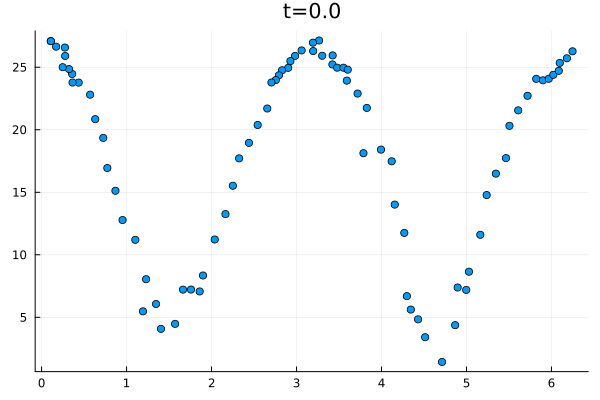

In [8]:
using Plots
p = Progress(convert(Int,model.Time.nₛₐᵥₑ+1),"Animating ...")
anim = @animate for t = 1:model.Time.nₛₐᵥₑ+1
    plot(
        agg.Simulation.Output.θr_data[t][:,1], 
        agg.Simulation.Output.θr_data[t][:,2], 
        title = "t=$((t-1)*model.Time.tₛᵢₘ/model.Time.nₛₐᵥₑ)",
        seriestype=:scatter,
        legend = false
    )
end

gif(anim, fps=2)

## xy data

┌ Info: Saved animation to /tmp/jl_4rKnEZexKh.gif
└ @ Plots /home/nicomosty/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_4rKnEZexKh.gif")
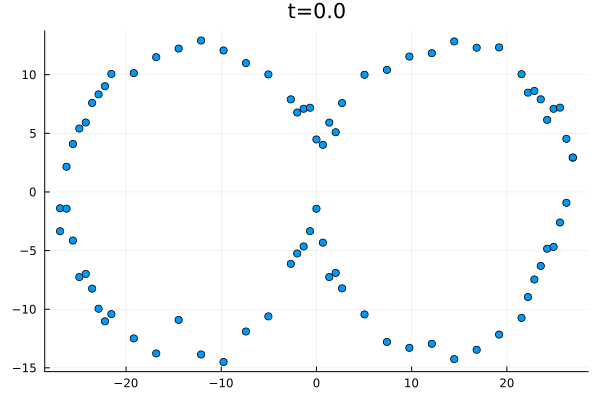

In [9]:
using Plots
p = Progress(convert(Int,model.Time.nₛₐᵥₑ+1),"Animating ...")
anim = @animate for t = 1:model.Time.nₛₐᵥₑ+1
    plot(
        agg.Simulation.Output.xy_data[t][:,1], 
        agg.Simulation.Output.xy_data[t][:,2], 
        title = "t=$((t-1)*model.Time.tₛᵢₘ/model.Time.nₛₐᵥₑ)",
        seriestype=:scatter,
        legend = false
    )
end

gif(anim, fps=2)